In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import time
np.set_printoptions(precision=4, suppress=True)
mpl.style.use('dark_background')

## Correlation functions

In [2]:
def pixel_corr(A, B):
    # A and B have shape N x m x n, where images are size m x n
    # find mean value of a single pixel over the N images
    shifted_A = A - np.mean(A, axis=0)
    shifted_B = B - np.mean(B, axis=0)
    # formula given above + perturbing denominator by
    # a small eps so that a constant series gets 
    # a correlation of 0 instead of Inf or NaN
    eps = 1e-10
    return (np.sum(shifted_A * shifted_B, axis=0)) \
                / (np.sqrt(np.sum(shifted_A**2, axis=0) \
                            * np.sum(shifted_B**2, axis=0)) + eps)

In [3]:
def uncent_pixel_corr(A, B):
    # A and B have shape N x m x n, where images are size m x n
    # find mean value of a single pixel over the N images
    # formula given above + perturbing denominator by
    # a small eps so that a constant series gets 
    # a correlation of 0 instead of Inf or NaN
    eps = 1e-10
    return (np.sum(A * B, axis=0)) \
                / (np.sqrt(np.sum(A**2, axis=0) \
                            * np.sum(B**2, axis=0)) + eps)

## Jacobian functions

In [4]:
@tf.function
def batch_JJt_diag(x, model):
    # note that x should be a tf.Variable with N vectors
    # of length n
    with tf.GradientTape() as tape:
        y = model(x)
    # if each output vector in y has length d then each
    # batch of Jacobians has shape N x d x n
    jacobians = tape.batch_jacobian(y, x)
    # the diagonal of JJt can be obtained via summing along
    # the third axis (size n) of the elementwise square
    # of the Jacobian. The batch of JJt diagonals will 
    # be size N x d 
    return tf.reduce_sum(jacobians**2, axis=2)

In [5]:
@tf.function
def batchJ(x, model):
    # note that x should be a tf.Variable with N vectors of 
    # length n
    with tf.GradientTape() as tape:
        y = model(x)
    # if each output vector in y has length d then each
    # batch of Jacobians has shape N x d x n
    return tape.batch_jacobian(y, x)

## Plotting functions

In [6]:
def plot_loss_history(loss_history, min_epoch):
    # set axes limits to adapt to chosen minimum epoch
    xmin, xmax = min_epoch, len(loss_history['loss'])
    ymin = np.min(loss_history['loss'][xmin:]\
                  + loss_history['val_loss'][xmin:])*0.9
    ymax = np.max(loss_history['loss'][xmin:]\
                  + loss_history['val_loss'][xmin:])*1.1

    fig, ax = plt.subplots(1,1,figsize=(8,6))
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    ax.plot(loss_history['loss'], label='loss')
    ax.plot(loss_history['val_loss'],
            label='validation loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Mean Squared Error')
    ax.set_yscale('log')
    ax.legend()
    plt.show()

In [7]:
def plot_images(left_images, right_images, main_title='TITLE',
               corr_scale=False):
    num_rows = len(left_images)
    fig, axs = plt.subplots(num_rows, 2,
                            figsize=(8, 4*num_rows),
                            constrained_layout=True)
    fig.suptitle(main_title, fontsize=20)
    
    # if the input images are correlations i.e. are bounded
    # to [-1,1], use Normalize class to apply transformation
    # on image that takes [-1,1], [0,1]
    corr_norm = mpl.colors.Normalize(vmin=-1, vmax=1)
    
    for i in range(num_rows):
        # annotate with range of image as title
        left_title = "Min: {0:.3}, Max: {1:.3}".format(
            np.min(left_images[i]),
            np.max(left_images[i]))
        axs[i,0].set_title(left_title)
        
        right_title = "Min: {0:.3}, Max: {1:.3}".format(
            np.min(right_images[i]),
            np.max(right_images[i]))      
        axs[i,1].set_title(right_title)
        
        # either apply correlation normalization or default
        # normalization which maps min and max to 0 and 1 
        if corr_scale:
            axs[i,0].imshow(left_images[i], cmap='gray', norm=corr_norm)
            axs[i,1].imshow(right_images[i], cmap='gray', norm=corr_norm)
        else:
            axs[i,0].imshow(left_images[i], cmap='gray')
            axs[i,1].imshow(right_images[i], cmap='gray')
    plt.show()

## Other functions

In [8]:
def mae(A, B):
    # A and B should be numpy arrays of the same size
    return np.mean(np.abs(A-B))
def rmse(A, B):
    # A and B should be numpy arrays of the same size
    return np.mean((A-B)**2)**0.5

## Initialize model

In [5]:
# INITIALIZE MODEL
loss_history = {'loss':[], 'val_loss':[]}
model = tf.keras.Sequential([
    tf.keras.layers.Dense(50000, activation='sigmoid',
                          input_shape=(5*image_size**2,)),
    tf.keras.layers.Dense(5000, activation='sigmoid'),
    tf.keras.layers.Dense(image_size**2)
])
loss_fn = tf.keras.losses.MeanSquaredError()
model.compile(tf.keras.optimizers.SGD(learning_rate=0.003, momentum=0.9),
                   loss=loss_fn)

## Train and save model

In [21]:
val_size = 1000
this_history = model.fit(x_train, y_train,
                         validation_data=(x_test[:val_size],y_test[:val_size]),
                         epochs=1, verbose=1, batch_size=25)
loss_history['loss'] += this_history.history['loss']
loss_history['val_loss'] += this_history.history['val_loss']

2400/2400 [==============================] - 2933s 1s/step - loss: 2.2965e-04 - val_loss: 1.1608e-04


In [25]:
model.save('random-image-model-10-sigmoid')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: random-image-model-10-sigmoid\assets


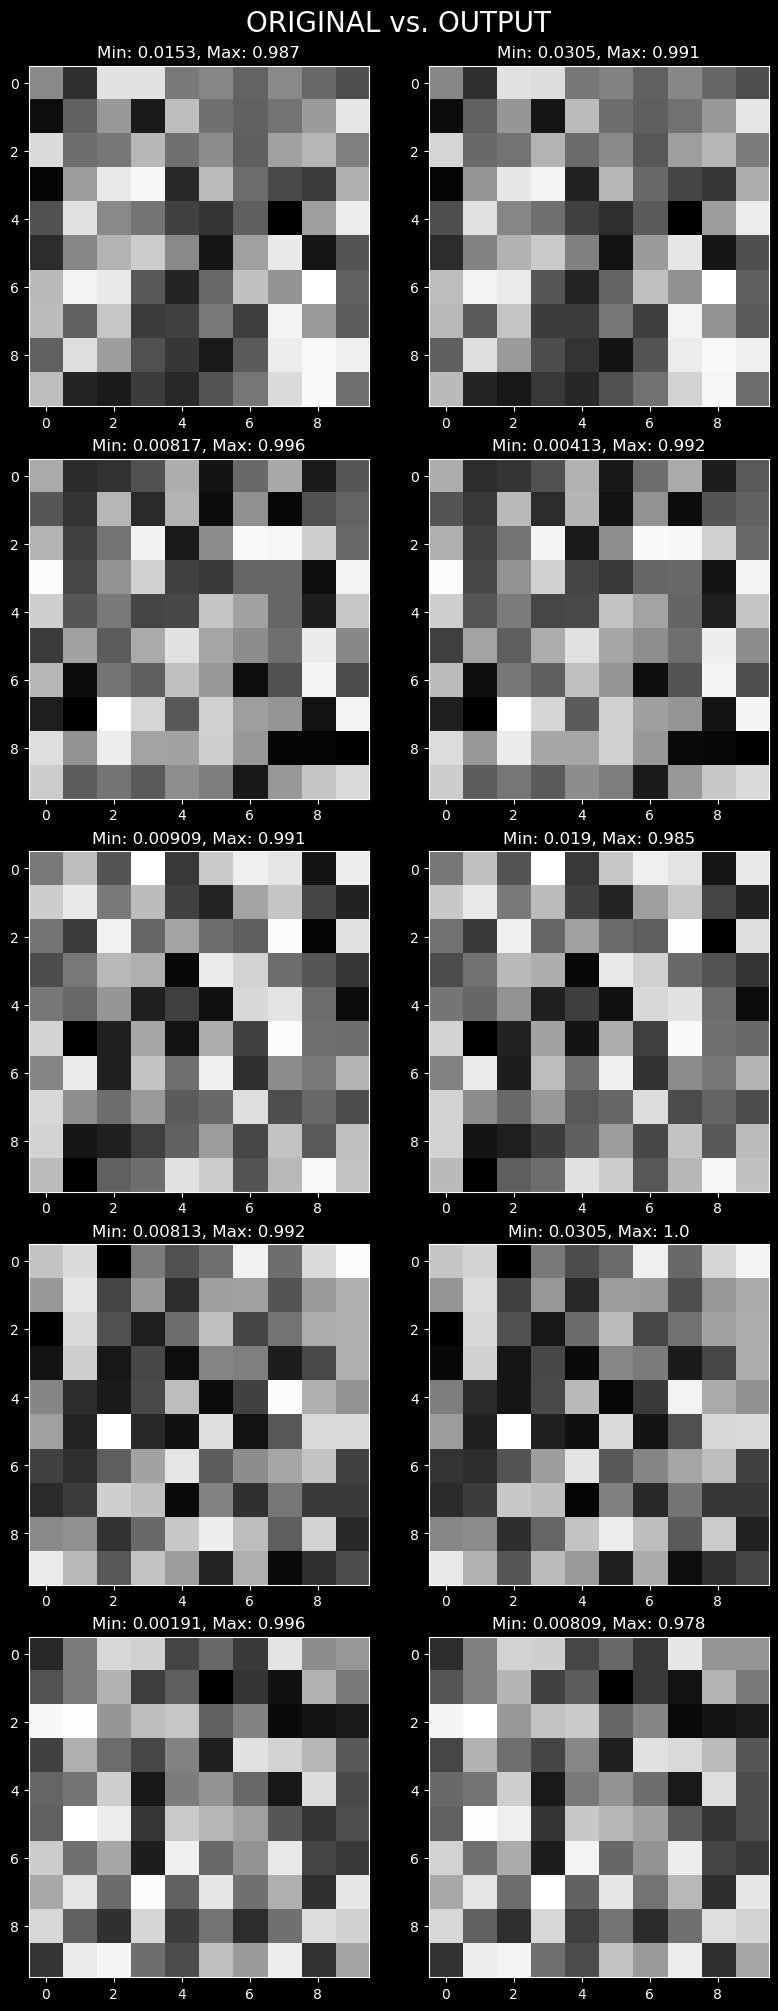

In [8]:
plot_images(np.reshape(y_test[0:5], (5,image_size,image_size)),
           np.reshape(model(x_test[:5]), (5,image_size,image_size)),
           main_title='ORIGINAL vs. OUTPUT')

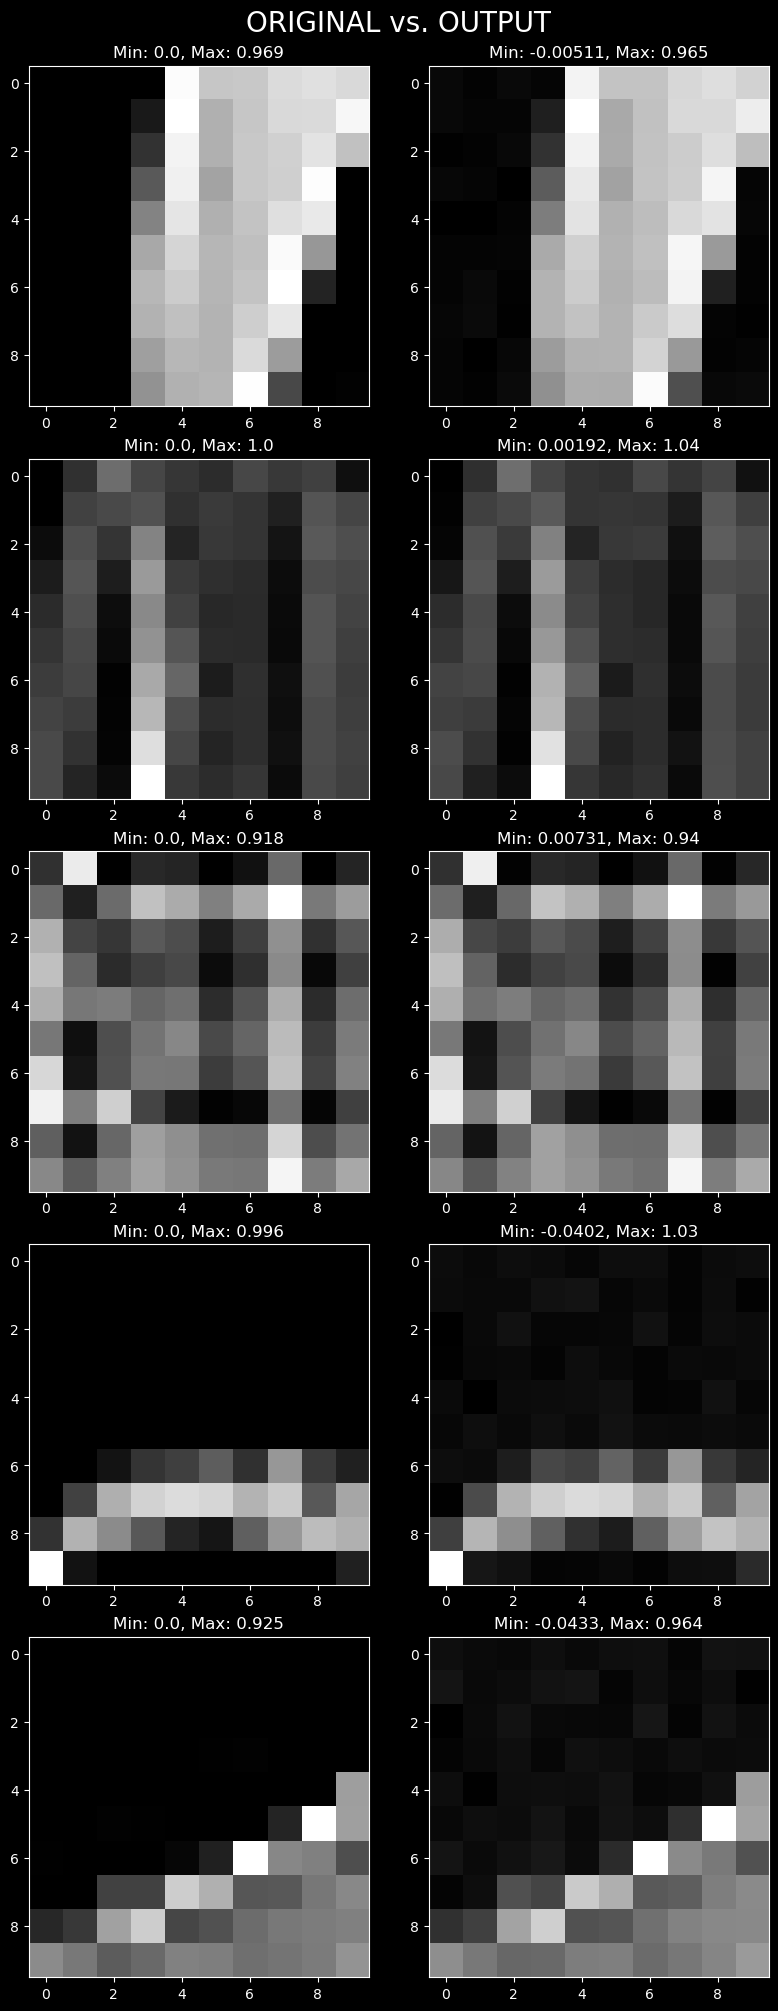

In [22]:
# crop 10x10 bits of the images
y_cropped = np.reshape(np.reshape(y_fash[5:10],(5,28,28))[:,5:15,5:15],
                       (5,100))
x_cropped = y_cropped @ A

plot_images(np.reshape(y_cropped, (5,image_size,image_size)),
           np.reshape(model(x_cropped), (5,image_size,image_size)),
           main_title='ORIGINAL vs. OUTPUT')

## Load data and model

In [9]:
# import encoded data from .npz archive
image_size = 10
with np.load('normally-encoded-random-images-10.npz') as data:
    x_train = data['x_train']
    x_test = data['x_test']
    y_train = data['y_train']
    y_test = data['y_test']
    A = data['A']
A_inv = np.linalg.pinv(A)

In [10]:
# import encoded data from .npz archive
with np.load('normally-encoded-fashion-mnist.npz') as data:
    y_fash = data['y_test']

In [11]:
model = tf.keras.models.load_model('random-image-model-10-sigmoid')

## 1. Comparison of J and $A^\#$
### The mean absolute error between J and $A^\#$ is ~30% of the mean absolute size of $A^\#$. This is basically constant over all of the encoded random images.

In [12]:
x = tf.Variable(x_test[0:25])
Js = batchJ(x, model)

In [14]:
J = Js[1]
print('A# MAE Norm:', mae(A_inv,0),
      'A# RMSE Norm:', rmse(A_inv,0))
print('J MAE Norm:', mae(J,0),
      'J RMSE Norm:', rmse(J,0))
print('MAE:', mae(J, A_inv.T),
    'RMSE:', rmse(J, A_inv.T))
print('MAE/A# MAE Norm:', mae(J, A_inv.T)/mae(A_inv,0))
print('RMSE/A# RMSE Norm:', rmse(J, A_inv.T)/rmse(A_inv,0))

A# MAE Norm: 0.001793299789740582 A# RMSE Norm: 0.0022488621738479433
J MAE Norm: 0.0018191617518273813 J RMSE Norm: 0.002281113307165151
MAE: 0.0005146035626505577 RMSE: 0.0006448589167301371
MAE/A# MAE Norm: 0.286959026926
RMSE/A# RMSE Norm: 0.2867489720931823


In [ ]:
## AinvAinvt_diag = np.diagonal(np.transpose(A_inv) @ A_inv)
JJt_diag = batch_JJt_diag(tf.Variable(x_test[0:1]), model)

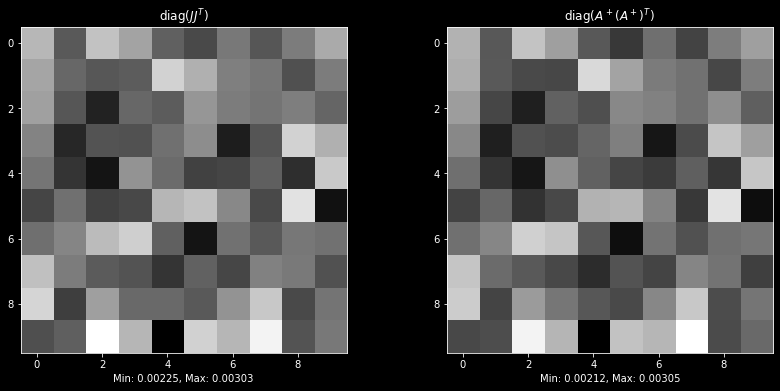

In [70]:
fig, axs = plt.subplots(1,2,figsize=(14,6))

axs[0].set_title('diag($J J^T$)')
axs[0].imshow(np.reshape(JJt_diag,(10,10)), cmap='gray')
axs[0].set_xlabel("Min: {0:.3}, Max: {1:.3}".format(
            np.min(JJt_diag), np.max(JJt_diag)))

axs[1].set_title('diag($A^+ (A^+)^T$)')
axs[1].imshow(np.reshape(AinvAinvt_diag,(10,10)), cmap='gray')
axs[1].set_xlabel("Min: {0:.3}, Max: {1:.3}".format(
            np.min(AinvAinvt_diag), np.max(AinvAinvt_diag)))
plt.show()

### Test data:

In [16]:
x = x_test[0:5]
y = model(x)
JJt_diags = batch_JJt_diag(tf.Variable(x), model)

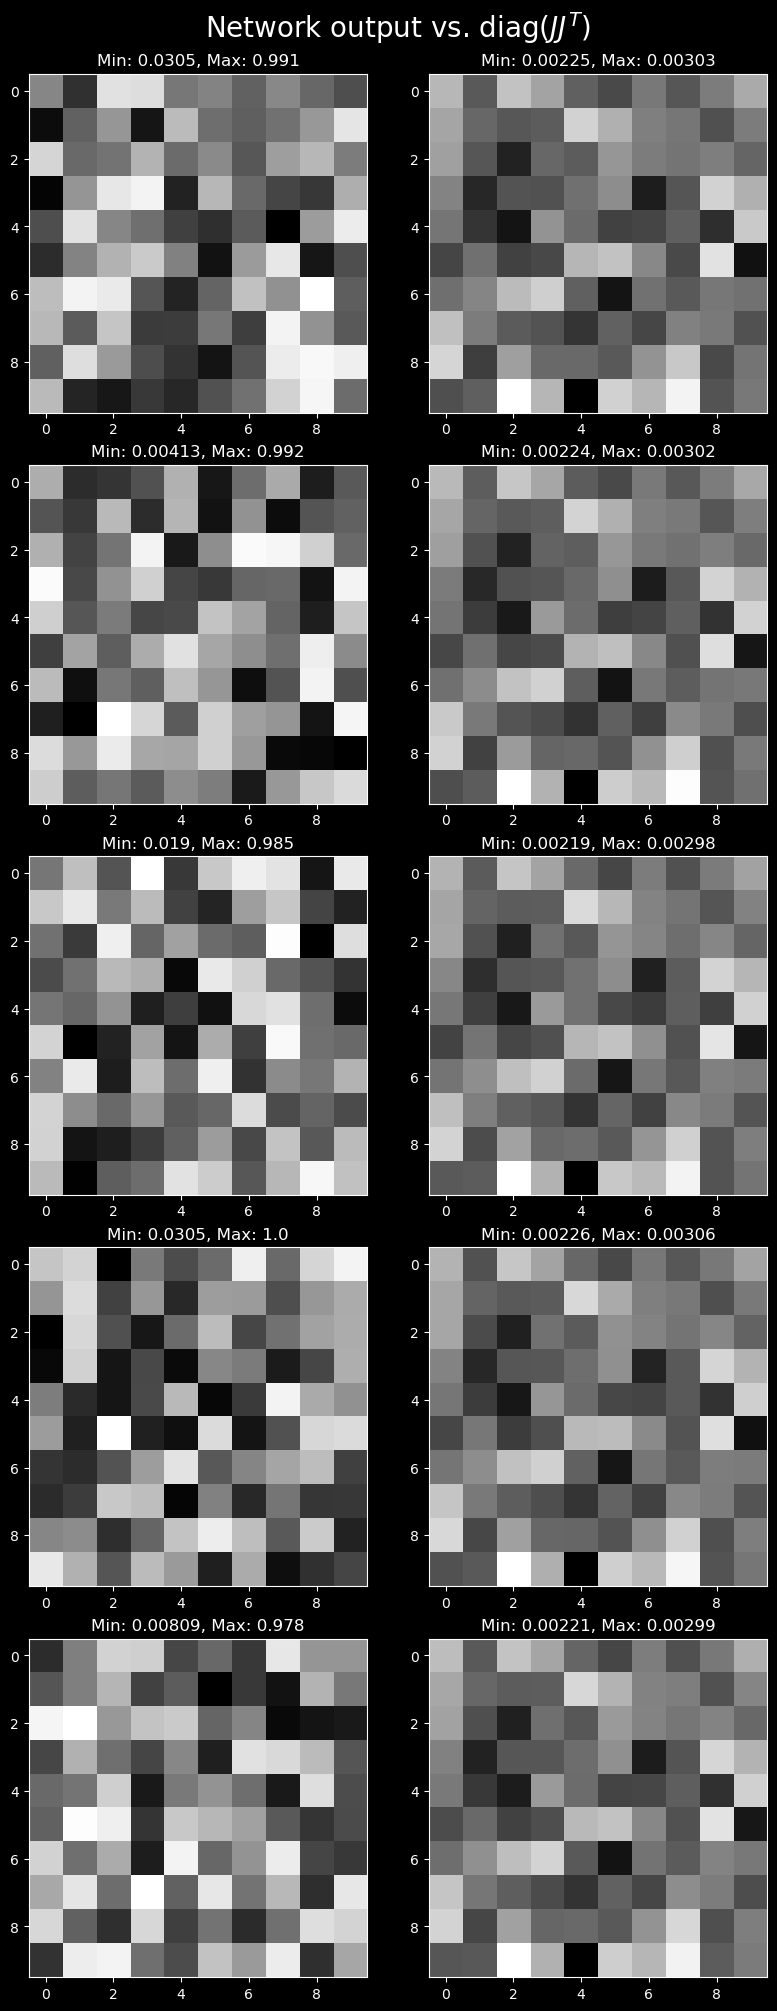

In [17]:
plot_images(np.reshape(y, (5,10,10)),
            np.reshape(JJt_diags, (5,10,10)),
            main_title = 'Network output vs. diag($J J^T$)')

### Fashion MNIST:

In [26]:
# crop 10x10 bits of the images
y_cropped = np.reshape(np.reshape(y_fash[0:5],(5,28,28))[:,5:15,5:15],(5,100))
x_cropped = y_cropped @ A
fashion_JJt_diags = batch_JJt_diag(tf.Variable(x_cropped), model)

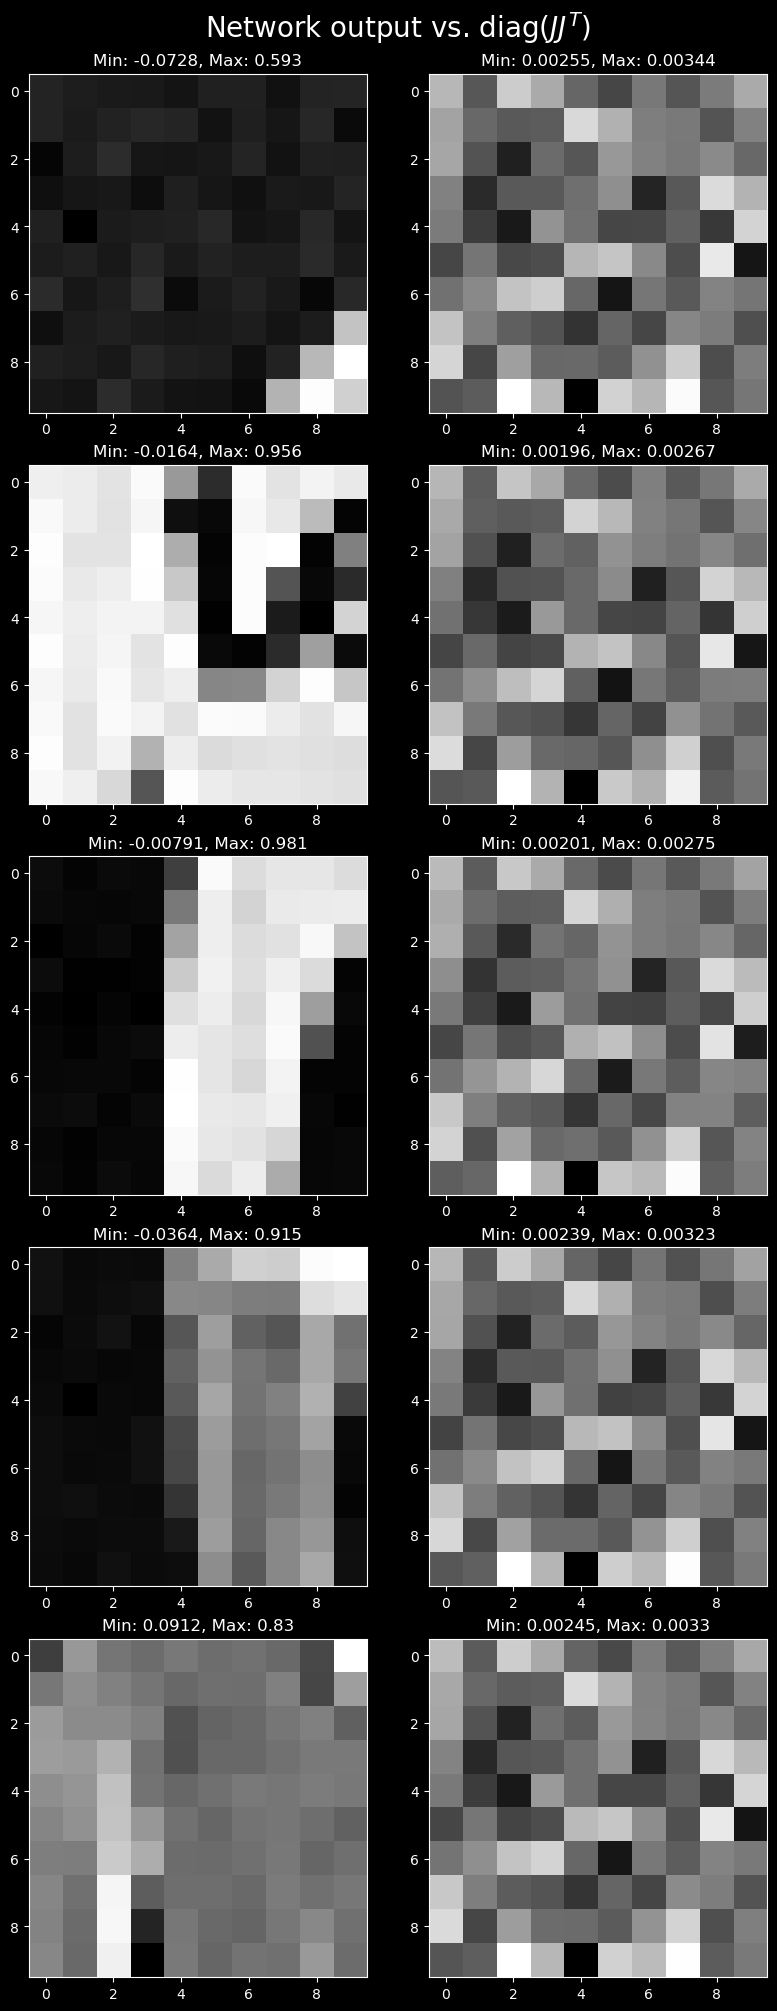

In [27]:
plot_images(np.reshape(model(x_cropped), (5,10,10)),
            np.reshape(fashion_JJt_diags, (5,10,10)),
            main_title = 'Network output vs. diag($J J^T$)')

## Pixelwise correlation of  $\sigma^2$ diag$(J J^T)$ and (noisy - reconstructed)$^2$ vs. $\sigma^2$

### Procedure: for each level of $\sigma$, add multiple realizations of Gaussian noise to a single clean image, calculate error image (noisy - reconstructed)^2 for each network output, then correlate to $\sigma^2$ diag$(J J^T)$ evaluated at each noisy input.

In [91]:
# Noisy reconstruction
N = 25
x = x_test[2:3,:] # choose image with the cross
levels = 10**np.linspace(-2,1,20) # exponentially spaced
sigmas = np.sqrt(np.max(x) * levels)

mean_devsq = np.zeros((len(sigmas),10,10))
corrs = np.zeros((len(sigmas),10,10))
uncent_corrs = np.zeros((len(sigmas),10,10))

for i, sigma in enumerate(sigmas):
    noise = sigma*np.random.randn(N, 5*image_size**2)
    x_noisy = x + noise

    y_recon = model(x)
    y_noisy = model(x_noisy)
    devsq = np.reshape((y_noisy-y_recon)**2, (N, image_size, image_size))
    JJt_diags =  np.reshape(batch_JJt_diag(tf.Variable(x_noisy), model),
                            (N, image_size, image_size))
    
    mean_devsq[i,:,:] = np.mean(devsq, axis=0)
    corrs[i,:,:] = pixel_corr(devsq, JJt_diags)
    uncent_corrs[i,:,:] = uncent_pixel_corr(devsq, JJt_diags)


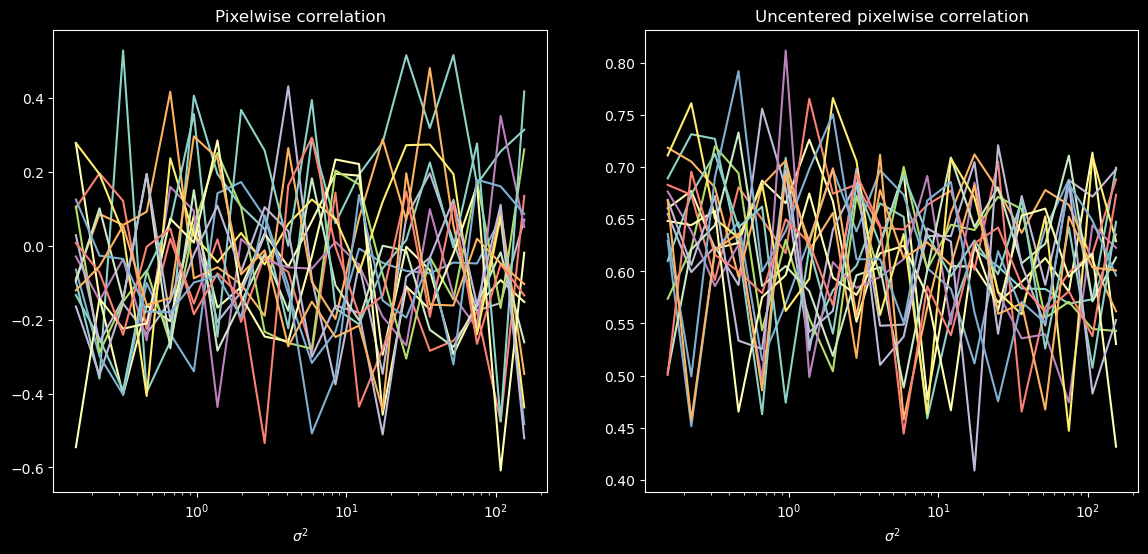

In [102]:
fig, axs = plt.subplots(1,2,figsize=(14,6))

axs[0].set_title('Pixelwise correlation')
axs[1].set_title('Uncentered pixelwise correlation')

axs[0].set_xlabel('$\sigma^2$')
axs[1].set_xlabel('$\sigma^2$')
for i in range(1,5):
    for j in range(1,5):
        axs[0].plot(sigmas**2, corrs[:,i,j])
        axs[1].plot(sigmas**2, uncent_corrs[:,i,j])
axs[0].set_xscale('log')
axs[1].set_xscale('log')

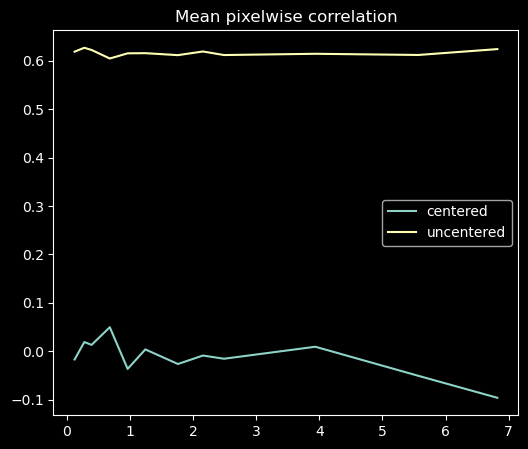

In [63]:
fig, ax = plt.subplots(1,1,figsize=(6,5))
ax.set_title('Mean pixelwise correlation')
ax.plot(sigmas, np.mean(corrs, (1,2)), label='centered')
ax.plot(sigmas, np.mean(uncent_corrs, (1,2)), label='uncentered')
ax.legend()
plt.show()

## MSE vs. $\sigma^2$
Have some linear model $\vec{y} = B \vec{x}$, so for perturbed input $\vec{x}' = \vec{x} + \sigma \vec{w}$, where each element of $\vec{w}$ is a sample from i.i.d. $N(0,1)$, have
$$\vec{y}' - \vec{y} = \sigma B \vec{w}$$
Look at the expectation of one entry of the elementwise square:
$$E[(y_i' - y_i)^2] = \sigma^2 E[(\Sigma_j B_{ij}w_j)^2]= \sigma^2 E[\Sigma_j(B_{ij}^2w_j^2) + \Sigma_j \Sigma_{k\neq j}(B_{ij}B_{ik}w_jw_k)] = \sigma^2 \Sigma_j B_{ij}^2$$
The last step using $E[w_j^2] = 1$ and $E[w_j w_k] = E[w_j] E[w_k] = 0$ for $j \neq k$. The last term is just the norm-squared of the i-th row a.k.a. the i-th diagonal entry of $B B^T$.

In [94]:
mean_devsq.shape

(20, 10, 10)

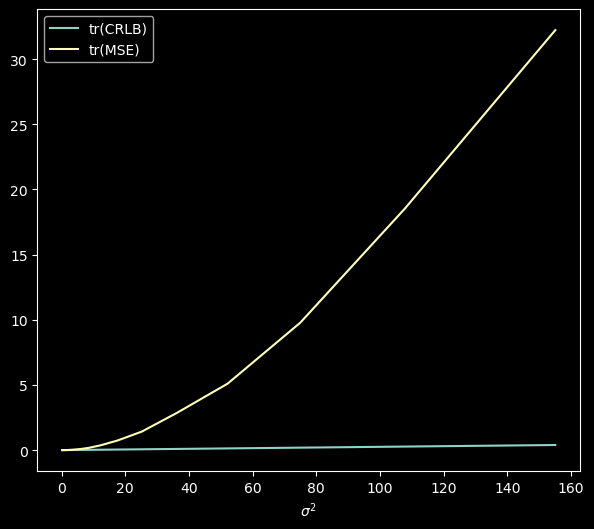

In [100]:
fig, ax = plt.subplots(1,1,figsize=(7,6))

trace_A = np.mean(AinvAinvt_diag)
trace_dev = np.mean(mean_devsq, (1,2))
ax.plot(sigmas**2, sigmas**2 * trace_A,
        label='tr(CRLB)')
ax.plot(sigmas**2, sigmas**2 * trace_dev,
        label='tr(MSE)')
ax.set_xlabel('$\sigma^2$')
ax.set_x
ax.legend()
plt.show()

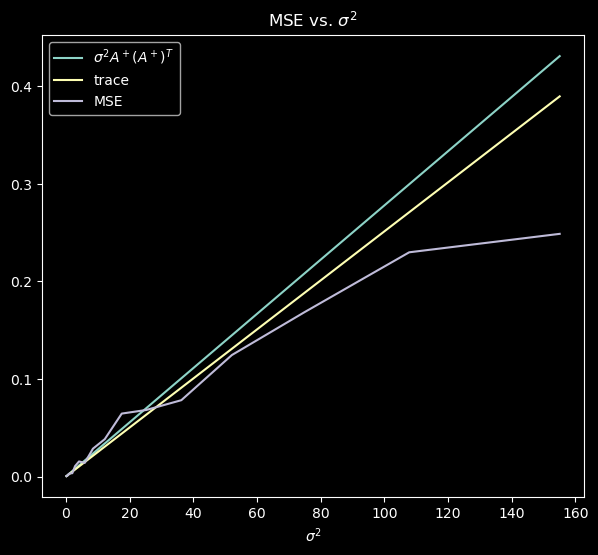

In [96]:
fig, ax = plt.subplots(1,1,figsize=(7,6))

i, j = 5, 5
ax.set_title('MSE vs. $\sigma^2$')
ax.set_xlabel('$\sigma^2$')

# plot ij-th component of sigma^2 diag(A+ (A+)T)               
ax.plot(sigmas**2, sigmas**2
        *np.reshape(AinvAinvt_diag,(10,10))[i,j],
        label='$\sigma^2 A^+(A^+)^T$')

# plot ij-th component of the mean deviation squared
ax.plot(sigmas**2, mean_devsq[:,i,j],
       label='MSE')
ax.legend()
plt.show()


## Grant proposal plots

In [13]:
# Noisy reconstruction
N = 100
x = x_test[2:3,:] # choose image with the cross
sigma = np.sqrt(0.3*np.max(x))
noise = sigma*np.random.randn(N, 5*image_size**2)
x_noisy = x + noise

y = y_test[2]
y_recon = model(x)
y_noisy = model(x_noisy)
devsq = (y_noisy-y_recon)**2

JJt_diags = batch_JJt_diag(tf.Variable(x_noisy[0:10]), model).numpy()

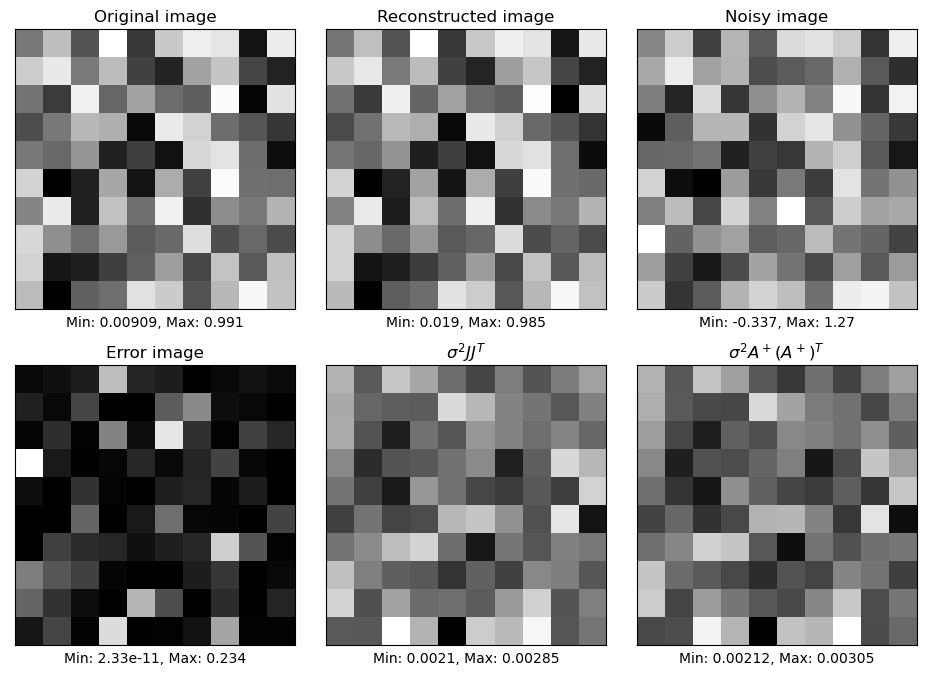

In [14]:
fig, axs = plt.subplots(2,3,figsize=(12,8))
fig.subplots_adjust(wspace=0.01, hspace=0.2)
axs[0,0].set_title('Original image')
axs[0,1].set_title('Reconstructed image')
axs[0,2].set_title('Noisy image')
axs[1,0].set_title('Error image')
axs[1,1].set_title('$\sigma^2 JJ^T$')
axs[1,2].set_title('$\sigma^2 A^+(A^+)^T$') 

# turn axes labels off for these images
for i in range(2):
    for j in range(3):
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        
# original image
axs[0,0].imshow(np.reshape(y,(10,10)), cmap='gray')
axs[0,0].set_xlabel("Min: {0:.3}, Max: {1:.3}".format(
            np.min(y), np.max(y)))

axs[0,1].imshow(np.reshape(y_recon,(10,10)), cmap='gray')
axs[0,1].set_xlabel("Min: {0:.3}, Max: {1:.3}".format(
            np.min(y_recon), np.max(y_recon)))

axs[0,2].imshow(np.reshape(y_noisy[1],(10,10)), cmap='gray')
axs[0,2].set_xlabel("Min: {0:.3}, Max: {1:.3}".format(
            np.min(y_noisy), np.max(y_noisy)))

axs[1,0].imshow(np.reshape(devsq[1],(10,10)), cmap='gray')
axs[1,0].set_xlabel("Min: {0:.3}, Max: {1:.3}".format(
            np.min(devsq), np.max(devsq)))

axs[1,1].imshow(np.reshape(sigma**2 * JJt_diags[0],(10,10)),
               cmap='gray')
axs[1,1].set_xlabel("Min: {0:.3}, Max: {1:.3}".format(
            np.min(sigma**2 JJt_diags[0]), np.max(JJt_diags[0])))

axs[1,2].imshow(np.reshape(sigma**2 * AinvAinvt_diag,(10,10)),
               cmap='gray')
axs[1,2].set_xlabel("Min: {0:.3}, Max: {1:.3}".format(
            np.min(AinvAinvt_diag), np.max(AinvAinvt_diag)))

plt.show()

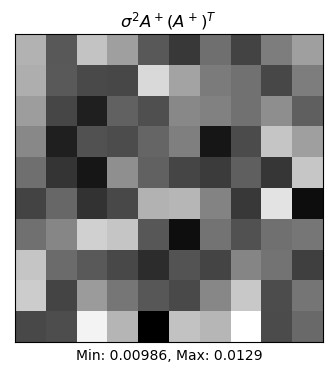

In [21]:
fig1, ax = plt.subplots(1,1,figsize=(4,4))
ax.set_xticks([])
ax.set_yticks([])

#mean_devsq = np.mean(devsq, axis=0)
ax.imshow(np.reshape(sigma**2 * AinvAinvt_diag,(10,10)), cmap='gray')
ax.set_xlabel("Min: {0:.3}, Max: {1:.3}".format(
            np.min(sigma**2 * AinvAinvt_diag), np.max(sigma**2 * AinvAinvt_diag[0])))
ax.set_title('$\sigma^2 A^+(A^+)^T$')

plt.savefig('pseudo-inv-image.pdf')